<a href="https://colab.research.google.com/github/chengruchou/RT-DETR-test/blob/main/RT_DETR_v2_finetune_on_a_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━

In [2]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [3]:
# @title Load model

CHECKPOINT = "PekingU/rtdetr_v2_r50vd"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

config.json:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
# @title Run inference

URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"

image = Image.open(requests.get(URL, stream=True).raw)
inputs = processor(image, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

w, h = image.size
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3)

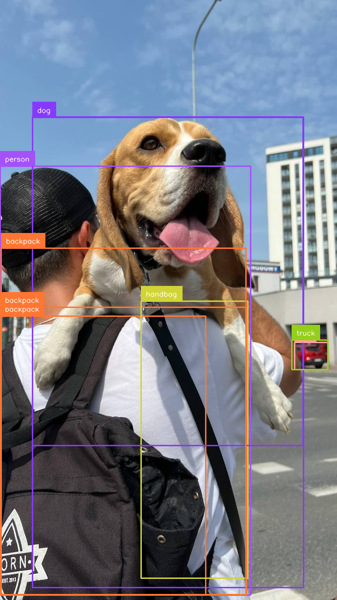

In [5]:
# @title Display result with NMS

detections = sv.Detections.from_transformers(results[0])
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
annotated_image.thumbnail((600, 600))
annotated_image

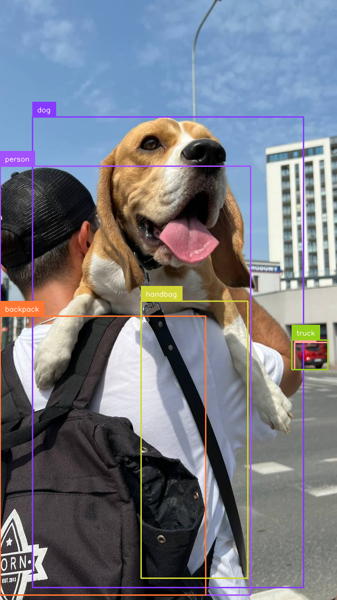

In [6]:
# @title Display result with NMS

detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
annotated_image.thumbnail((600, 600))
annotated_image

In [7]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ynvPp1noiph3TmelaKST")
project = rf.workspace("wisard").project("wisard_vis")
version = project.version(4)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to US-Coins-1 in coco:: 100%|██████████| 128/128 [00:00<00:00, 2548.02it/s]


In [8]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)


print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
# print(f"Number of test images: {len(ds_test)}")

Number of training images: 105
Number of validation images: 10


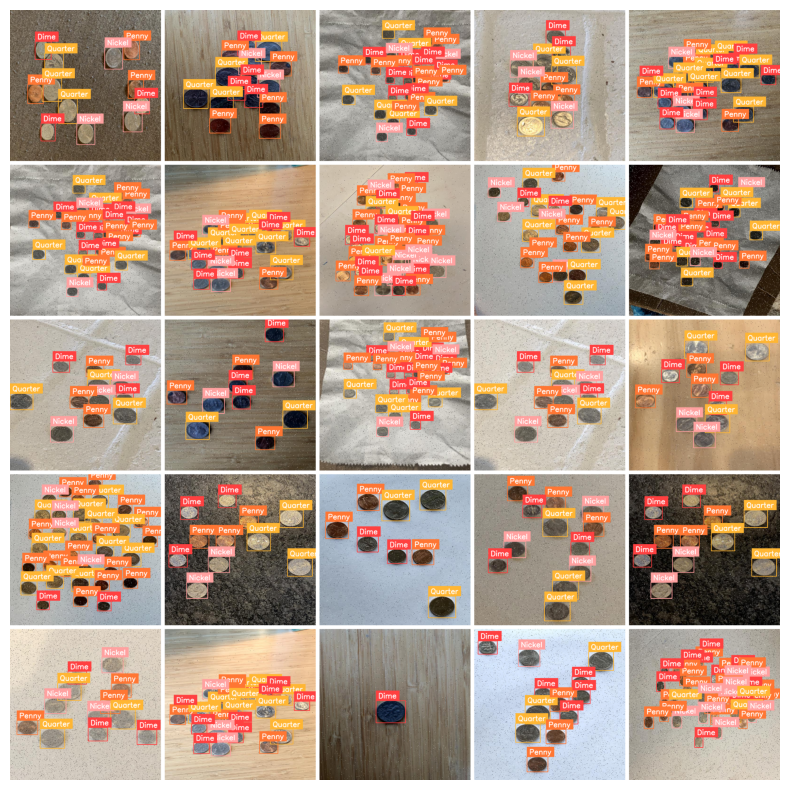

In [9]:
# @title Display dataset sample

GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]
    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

In [10]:
IMAGE_SIZE = 640

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

In [11]:
train_augmentation_and_transform = A.Compose(
    [A.NoOp(),],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

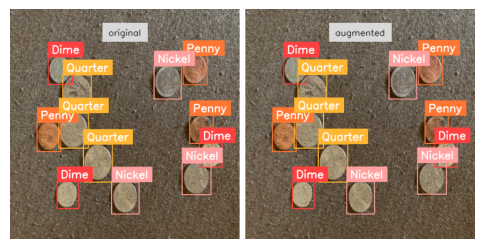

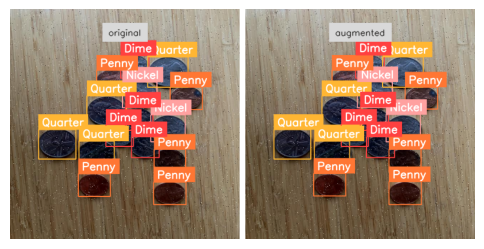

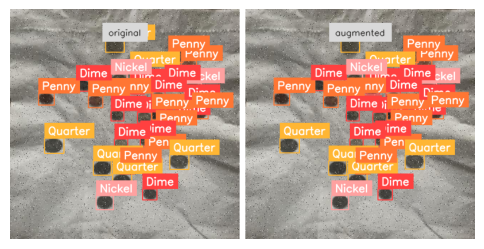

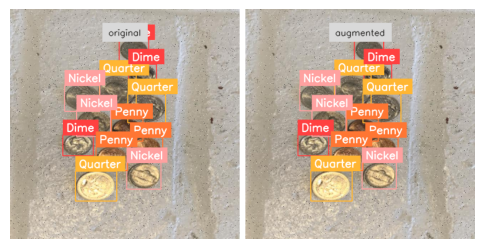

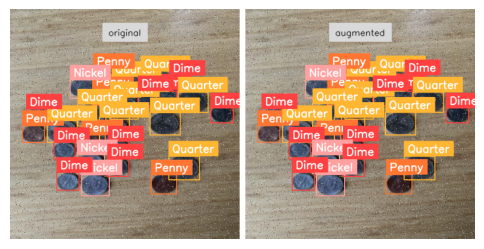

In [12]:
# @title Visualize some augmented images

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [13]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

In [14]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)


pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.6706, 0.6745, 0.7176,  ..., 0.8039, 0.7725, 0.8353],
          [1.0000, 0.6118, 0.7569,  ..., 0.8196, 0.7686, 0.8784],
          [0.6706, 0.7373, 0.6784,  ..., 0.8627, 0.8314, 0.7608],
          ...,
          [0.7059, 0.5882, 0.7725,  ..., 0.6353, 0.6353, 0.6392],
          [0.7412, 0.7608, 0.6078,  ..., 0.6353, 0.6353, 0.6353],
          [0.6784, 0.6784, 0.7765,  ..., 0.6353, 0.6314, 0.6353]],
 
         [[0.6667, 0.6706, 0.7137,  ..., 0.8549, 0.8235, 0.8863],
          [1.0000, 0.6078, 0.7529,  ..., 0.8706, 0.8196, 0.9294],
          [0.6667, 0.7333, 0.6745,  ..., 0.9137, 0.8824, 0.8118],
          ...,
          [0.7059, 0.5882, 0.7725,  ..., 0.6824, 0.6824, 0.6863],
          [0.7412, 0.7608, 0.6078,  ..., 0.6824, 0.6824, 0.6824],
          [0.6784, 0.6784, 0.7765,  ..., 0.6824, 0.6784, 0.6824]],
 
         [[0.6471, 0.6510, 0.6941,  ..., 0.8902, 0.8588, 0.9216],
          [0.9804, 0.5882, 0.7333,  ..., 0.9059, 0.8549, 0.9647],
          [0.6471, 0.713

In [15]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

In [20]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            # batch_image_sizes = torch.tensor(np.array([[x["size"], x["size"]] for x in batch]))
            batch_image_sizes = torch.tensor(np.array([[x["size"], x["size"]] for x in batch]))[:, 0, :]
            # batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

In [17]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decod

In [21]:
training_args = TrainingArguments(
    output_dir=f"{dataset.name.replace(' ', '-')}-finetune",
    num_train_epochs=1,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=32,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    processing_class=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Dime,Mar 100 Dime,Map Nickel,Mar 100 Nickel,Map Penny,Mar 100 Penny,Map Quarter,Mar 100 Quarter
1,No log,60.915703,0.000200,0.000300,0.000300,-1.000000,0.000400,0.000000,0.000000,0.000000,0.010900,-1.000000,0.013100,0.000000,0.000000,0.000000,0.000000,0.023100,0.000000,0.000000,0.000600,0.020700
2,No log,59.403454,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.005800,-1.000000,0.006300,0.000000,0.000000,0.000000,0.000000,0.023100,0.000000,0.000000,0.000000,0.000000


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

TrainOutput(global_step=8, training_loss=68.79963684082031, metrics={'train_runtime': 12.8605, 'train_samples_per_second': 16.329, 'train_steps_per_second': 0.622, 'total_flos': 6.6167188512768e+16, 'train_loss': 68.79963684082031, 'epoch': 2.0})

In [23]:
rf = Roboflow(api_key="sX1IIXHse2E67OveKewO")
project = rf.workspace("sard-wb2un").project("sard-peykp-0tqlq")
version = project.version(1)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SARD-1 in coco:: 100%|██████████| 1984/1984 [00:02<00:00, 670.59it/s]


In [24]:
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

In [25]:
# @title Collect predictions

targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [26]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.02
map50: 0.07
map75: 0.02


In [29]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot()

IndexError: index 4 is out of bounds for axis 1 with size 3

In [ ]:
model.save_pretrained("/content/rt-detr/")
processor.save_pretrained("/content/rt-detr/")

In [ ]:
IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))